# Tennis Aces Regression

The objective of this modeling and analysis, is to create a model that will accurately predict the average number of aces a profession tennis player will hit in a match. The data was gathered in Early April 2019.

In [1]:
# SciPy Stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Standard Library
import warnings

# Seaborn
import seaborn as sns

# Statsmodels
import statsmodels.api as sm

In [2]:
tennis = pd.read_csv('tennis_aces_ver2.csv', encoding='UTF-8')

### Exploratory Data Analysis and Cleaning

In [3]:
tennis.isnull().any() # There are some missing values for women

Player                     False
1stServe%                  False
1st_Serve%_Points_Won      False
2nd_Serve%_Points_Won      False
Service%_Games_Won         False
Avg_Aces/Match             False
Avg_Double_Faults/Match    False
Age                        False
Height                      True
Weight                      True
Gender                     False
dtype: bool

In [4]:
# Rename columns
tennis.columns = ['Player', '1stServe_perc', '1st_Serve_perc_Points_Won',
       '2nd_Serve_perc_Points_Won', 'Service_perc_Games_Won', 'Avg_Aces_Match', 'Avg_Double_Faults_Match', 'Age',
       'Height', 'Weight', 'Gender']

In [5]:
cols = list(tennis)
cols.insert(0, cols.pop(cols.index('Avg_Aces_Match')))
tennis = tennis.loc[:,cols] # Moves Avg_Aces/Match to the first column to make slicing easier

In [6]:
# Drop co-linear feature
tennis = tennis.drop('Service_perc_Games_Won', axis=1)

In [7]:
def clean_headers(df):
    df.columns = [column.strip() for column in df.columns]
    df.columns = map(str.lower, df.columns)
    return df.columns

In [8]:
clean_headers(tennis)

Index(['avg_aces_match', 'player', '1stserve_perc',
       '1st_serve_perc_points_won', '2nd_serve_perc_points_won',
       'avg_double_faults_match', 'age', 'height', 'weight', 'gender'],
      dtype='object')

In [9]:
def set_player_as_index(df):
    return df.set_index('player', inplace=True)

In [10]:
set_player_as_index(tennis)

Here I decided it would be best to make three models instead of one. 

These models are:
* A model that makes predictions amongst all players
* A model for the men only
* A model for the women only

Since the weight of all the women are missing, weight can only be a factor for the men. It wouldn't make sense to fill in weights for women players based on the men. 

In [11]:
# Create two separate DataFrame split on gender
tennis_women = tennis[tennis.gender=='Female']
tennis_men = tennis[tennis.gender=='Male']

In [12]:
tennis_men.isnull().any()

avg_aces_match               False
1stserve_perc                False
1st_serve_perc_points_won    False
2nd_serve_perc_points_won    False
avg_double_faults_match      False
age                          False
height                       False
weight                       False
gender                       False
dtype: bool

In [13]:
tennis_women.isnull().any()

avg_aces_match               False
1stserve_perc                False
1st_serve_perc_points_won    False
2nd_serve_perc_points_won    False
avg_double_faults_match      False
age                          False
height                        True
weight                        True
gender                       False
dtype: bool

In [14]:
def fill_player_height(df):
    return df.height.fillna(np.mean(df.height), inplace=True)

Since there are only a few heights that are missing, and the hieght of women players tend to be close to one another, I decided to fill in the missing values with the average height of all the women players.

In [15]:
fill_player_height(tennis)
fill_player_height(tennis_women)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
#drop the weight column from the women's DataFrame and combined DataFrame.
tennis_women.drop(['weight', 'gender'], inplace=True, axis=1)
tennis_men.drop('gender', inplace=True, axis=1)
tennis.drop('weight', inplace=True, axis=1)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
def dummify(df):
    '''create dummy variables for the gender column'''
    df.gender = pd.get_dummies(df.gender, drop_first=True)
    df['gender'] = pd.get_dummies(df['gender'], drop_first=True)
    return df

In [18]:
dummify(tennis)
print(tennis.head(1))

            avg_aces_match  1stserve_perc  1st_serve_perc_points_won  \
player                                                                 
John Isner            22.8           71.0                       81.6   

            2nd_serve_perc_points_won  avg_double_faults_match  age  height  \
player                                                                        
John Isner                       57.9                      2.2   33   208.0   

            gender  
player              
John Isner       1  


In [19]:
# Some naive models just to examine some trend before modeling
def make_naive_linear_model(df, target, other_variables):
    '''
    target is a series from a dataframe,
    other_variables is a list of the other features in the dataframe.
    '''
    naive_lr = sm.OLS(target, other_variables).fit()
    print(naive_lr.summary())
    
    return naive_lr

In [20]:
avg_aces = tennis.iloc[:, 0]
other_serve_stats = tennis.iloc[:, 1:]

Some naive models to see how strong of a linear relationship there is will all variables included.

In [21]:
print('Naive Model:')
make_naive_linear_model(tennis, avg_aces, other_serve_stats)

Naive Model:
                            OLS Regression Results                            
Dep. Variable:         avg_aces_match   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     124.3
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           2.85e-60
Time:                        16:27:59   Log-Likelihood:                -379.57
No. Observations:                 162   AIC:                             773.1
Df Residuals:                     155   BIC:                             794.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
1stserve_

In [22]:
men_avg_aces = tennis_men.iloc[:, 0]
men_other_serve_stats = tennis_men.iloc[:, 1:]
print('Naive Men\'s Model:')
make_naive_linear_model(tennis_men, men_avg_aces, men_other_serve_stats)

Naive Men's Model:
                            OLS Regression Results                            
Dep. Variable:         avg_aces_match   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     68.23
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           6.06e-30
Time:                        16:27:59   Log-Likelihood:                -207.85
No. Observations:                  82   AIC:                             429.7
Df Residuals:                      75   BIC:                             446.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
1st

In [23]:
women_avg_aces = tennis_women.iloc[:, 0]
women_other_serve_stats = tennis_women.iloc[:, 1:]
print('Naive Women\'s Model:')
make_naive_linear_model(tennis_women, women_avg_aces, women_other_serve_stats)

Naive Women's Model:
                            OLS Regression Results                            
Dep. Variable:         avg_aces_match   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     145.2
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           7.36e-39
Time:                        16:27:59   Log-Likelihood:                -119.11
No. Observations:                  80   AIC:                             250.2
Df Residuals:                      74   BIC:                             264.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
1

The r-squared implies there might be a really strong linear relationship.

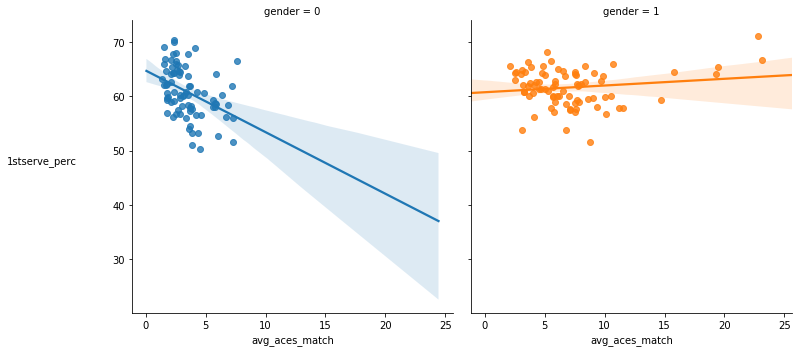

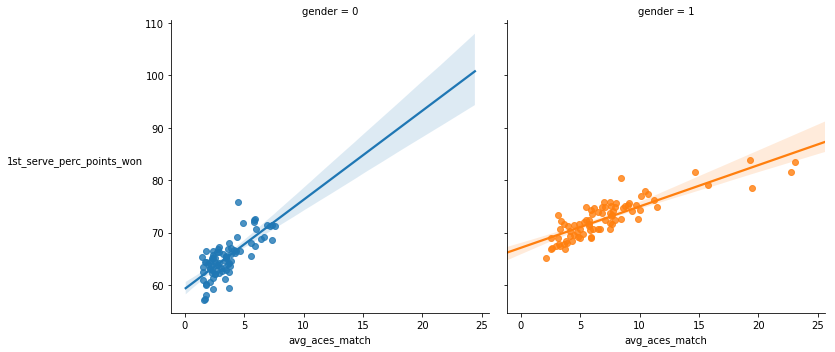

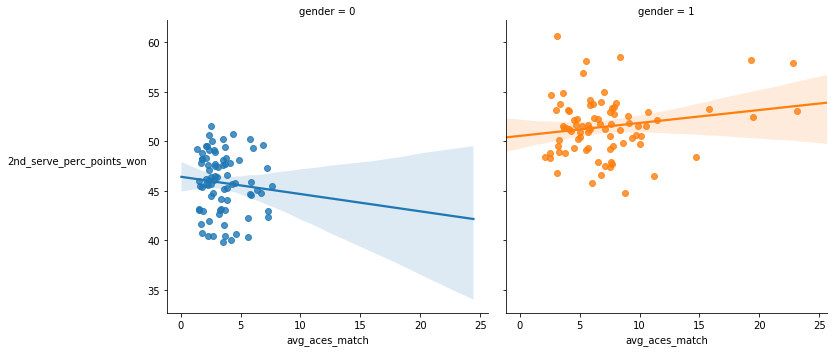

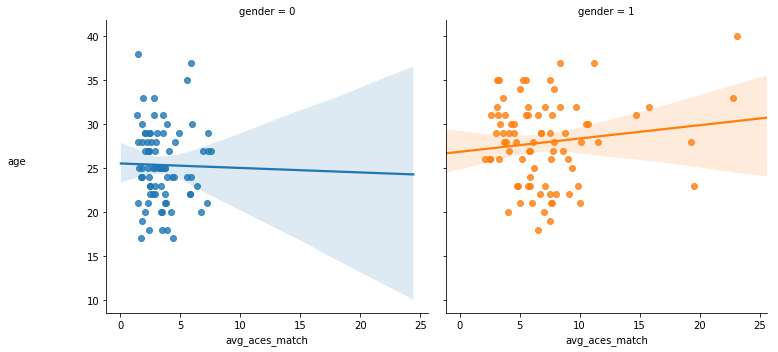

In [24]:
for feature in list(tennis.columns.drop(['avg_aces_match', 'gender'])):
    sns.lmplot(x='avg_aces_match', y=feature, hue='gender', col='gender', data=tennis).set_ylabels(rotation=0, labelpad=70);

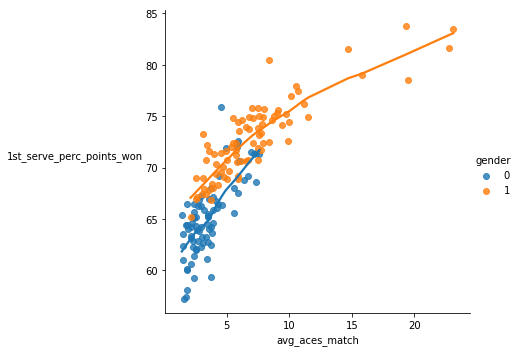

In [25]:
for feature in list(tennis.columns.drop(['avg_aces_match', 'gender'])):
    sns.lmplot(x='avg_aces_match', y=feature, data=tennis, hue='gender', lowess=True).set_ylabels(rotation=0, labelpad=70);

In [26]:
g = sns.lmplot(x='avg_aces_match', y='1st_serve_perc_points_won', data=tennis, hue='gender', lowess=True, legend_out=False).set_ylabels(rotation=0, labelpad=70,)
g.set_xlabels(label='Average\n Aces per Match', fontsize= 16, labelpad=10)
g.set_xticklabels(fontsize=12)
g.set_ylabels(label='1st Serve\n Percentage Points Won', fontsize=14, labelpad=90)
g.set_yticklabels(fontsize=12)
plt.legend(loc='center right', labels=['Female', 'Male'], fancybox=True, framealpha=0)
# plt.title('Lowess 1st Serve Perc Points Won vs. Avg Aces per Match')
plt.show(g)
g.savefig('lowess_1st_serve.svg', format='svg', transparent=True);

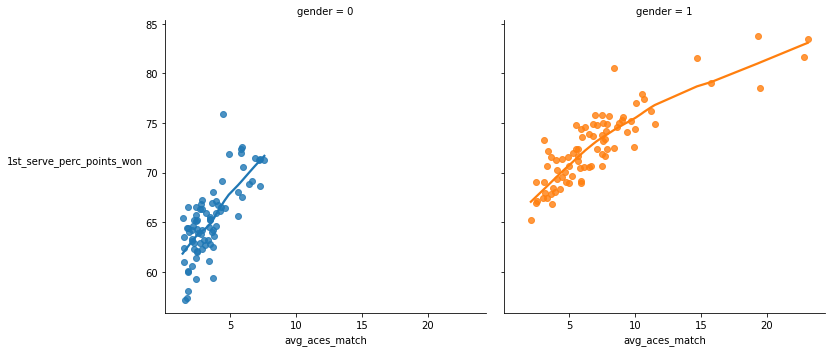

In [27]:
sns.lmplot(x='avg_aces_match', y='1st_serve_perc_points_won', data=tennis, hue='gender', col='gender', lowess=True, legend_out=False).set_ylabels(rotation=0, labelpad=70);
# fig.savefig(‘filename.svg’, format=’svg’)

Locally Weighted Scatterplot Smoothing looks like there might be a logarithmic relationship between 1st serve percentage points won and the average aces per match.

In [28]:
X = tennis.drop('avg_aces_match', axis=1)
y = tennis['avg_aces_match']
X_men = tennis_men.drop('avg_aces_match', axis=1)
y_men = tennis_men['avg_aces_match']
X_women = tennis_women.drop('avg_aces_match', axis=1)
y_women = tennis_women['avg_aces_match']

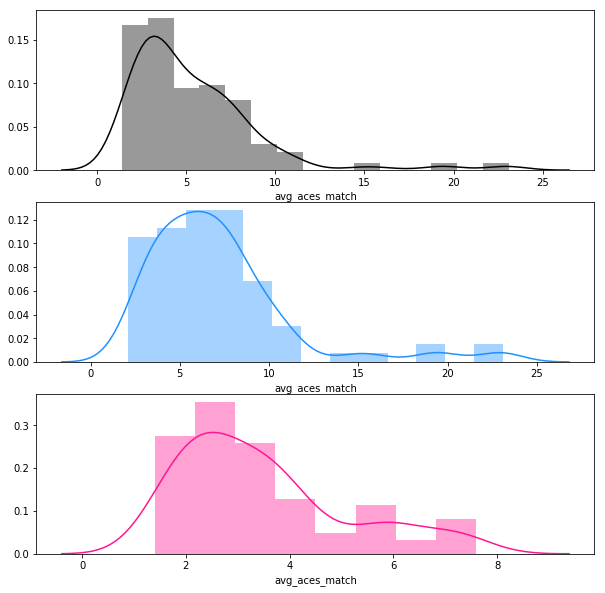

In [29]:
plt.subplots(3, 1, figsize=(10,10),sharex=True);
plt.subplot(3,1,1)
sns.distplot(y, color='k');

plt.subplot(3,1,2)
sns.distplot(y_men, color='dodgerblue');

plt.subplot(3,1,3)
sns.distplot(y_women, color='deeppink');

There appears to be some outliers for the men. 

## Time for some modeling
### First up is simple train test split

In [30]:
def split_and_test(X, y, test_size=0.25, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    linreg = LinearRegression().fit(X_train, y_train)
    test_score = round(linreg.score(X_test, y_test), 3)
    print(f'Test R^2 Score: , {test_score}\n')
    print(f'Feature coefficient results:')
    coefficients = [f'{feature} : {round(coef, 2)}' for feature, coef in zip(X.columns, linreg.coef_)]
    for coef in coefficients:
        print(coef)
    return X_train, X_test, y_train, y_test, linreg, test_score, coefficients

In [31]:
X_train, X_test, y_train, y_test, linreg, test_score, standard_coefs = split_and_test(X, y, test_size=0.2, random_state=10)

Test R^2 Score: , 0.811

Feature coefficient results:
1stserve_perc : 0.17
1st_serve_perc_points_won : 0.58
2nd_serve_perc_points_won : -0.06
avg_double_faults_match : 0.29
age : -0.0
height : 0.1
gender : -1.41


In [32]:
men_X_train, men_X_test, men_y_train, men_y_test, men_linreg, men_test_score, men_coefs = split_and_test(X_men, y_men, test_size=0.2, random_state=10)

Test R^2 Score: , 0.479

Feature coefficient results:
1stserve_perc : 0.33
1st_serve_perc_points_won : 0.86
2nd_serve_perc_points_won : -0.21
avg_double_faults_match : 0.43
age : 0.05
height : 0.09
weight : 0.02


In [33]:
women_X_train, women_X_test, women_y_train, women_y_test, women_linreg, women_test_score, women_coefs = split_and_test(X_women, y_women, test_size=0.2, random_state=10)

Test R^2 Score: , 0.543

Feature coefficient results:
1stserve_perc : -0.01
1st_serve_perc_points_won : 0.32
2nd_serve_perc_points_won : -0.12
avg_double_faults_match : -0.02
age : 0.0
height : 0.04


In [34]:
def plot_residuals(X_test, y_test):
    return plt.scatter(linreg.predict(X_test), y_test - linreg.predict(X_test));

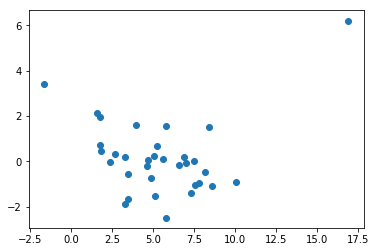

In [35]:
# Plotting residuals; quick check
plot_residuals(X_test, y_test);

In [36]:
y_pred = linreg.predict(X_test)
men_y_pred = men_linreg.predict(men_X_test)
women_y_pred = women_linreg.predict(women_X_test)

In [37]:
# Creating MAPE function
def mean_absolute_percentage_error(y_testing, y_pred):
    return round(np.mean(np.abs(y_pred-y_testing)), 5)

In [38]:
def make_regression_metrics(model, X_testing, y_testing, y_preding, rounding=5):
    MAE = round(mean_absolute_error(y_testing, y_preding), rounding)
    MSE = round(mean_squared_error(y_testing, y_preding), rounding)
    MAPE = mean_absolute_percentage_error(y_testing, y_preding)
    MedAE = round(median_absolute_error(y_testing, y_preding), rounding)
    R_squared = round(model.score(X_testing, y_testing), rounding)
    metric_names = ['MAE', 'MSE', 'MAPE', 'MedAE', 'R_squared']
    metric_df = pd.DataFrame(columns=metric_names, index=['Linear Regression'])
    metric_df['MAE'] = MAE
    metric_df['MSE'] = MSE
    metric_df['MAPE'] = MAPE
    metric_df['MedAE'] = MedAE
    metric_df['R_squared'] = R_squared
    return metric_df.T

In [39]:
combined_metrics = make_regression_metrics(linreg, X_test, y_test, y_pred)
print(combined_metrics)

           Linear Regression
MAE                  1.11345
MSE                  2.71954
MAPE                 1.11345
MedAE                0.73690
R_squared            0.81143


In [40]:
men_metrics = make_regression_metrics(men_linreg, men_X_test, men_y_test, men_y_pred)
print(men_metrics)

           Linear Regression
MAE                  1.41275
MSE                  3.03098
MAPE                 1.41275
MedAE                1.29555
R_squared            0.47927


In [41]:
women_metrics = make_regression_metrics(women_linreg, women_X_test, women_y_test, women_y_pred)
print(women_metrics)

           Linear Regression
MAE                  0.70211
MSE                  0.84053
MAPE                 0.70211
MedAE                0.49607
R_squared            0.54310


In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
print(f"Combined cross_val_score: {round(np.mean(cross_val_score(linreg, X, y, cv=kf, scoring='r2')), 5)}")
print(f"Men's cross_val_score: {round(np.mean(cross_val_score(men_linreg, X_men, y_men, cv=kf, scoring='r2')), 5)}")
print(f"Women's cross_val_score: {round(np.mean(cross_val_score(women_linreg, X_women, y_women, cv=kf, scoring='r2')), 5)}")

Combined cross_val_score: 0.70938
Men's cross_val_score: 0.67825
Women's cross_val_score: 0.48456


## Cross Validation for Combined Genders

In [43]:
warnings.filterwarnings("ignore")

In [44]:
def standard_cross_val_metrics(model, X, y,  rounding=5, random_state=10):
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    MAE = round(np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')), 5)*-1
    MSE = round(np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')), 5)*-1
    MedAE = round(np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_median_absolute_error')), 5)*-1
    R_squared = round(np.mean(cross_val_score(model, X, y, cv=kf, scoring='r2')), 5)
    metric_names = ['MAE', 'MSE', 'MedAE', 'R_squared']
    metric_df = pd.DataFrame(columns=['OLS'], index=metric_names)
    metric_df['OLS'] = MAE, MSE, MedAE, R_squared
    coefficients = [f'{feature}: {round(coef, 5)}' for feature, coef in zip(X.columns, model.coef_)]
    return metric_df, coefficients

In [45]:
def print_coefficients(coefficients_list):
    for model in coefficients_list:
        for feature in model:
            print(feature)
        print('\n')

In [46]:
combined_standard, combined_linreg_coefficients = standard_cross_val_metrics(linreg, X, y)
men_standard, men_linreg_coefficients = standard_cross_val_metrics(men_linreg, X_men, y_men)
women_standard, women_linreg_coefficients = standard_cross_val_metrics(women_linreg, X_women, y_women)

In [47]:
linreg_coefficients = [combined_linreg_coefficients, men_linreg_coefficients, women_linreg_coefficients]
print_coefficients(linreg_coefficients)

1stserve_perc: 0.1673
1st_serve_perc_points_won: 0.58495
2nd_serve_perc_points_won: -0.05912
avg_double_faults_match: 0.28551
age: -0.00079
height: 0.09567
gender: -1.41262


1stserve_perc: 0.33454
1st_serve_perc_points_won: 0.85657
2nd_serve_perc_points_won: -0.20998
avg_double_faults_match: 0.4291
age: 0.05175
height: 0.08879
weight: 0.02241


1stserve_perc: -0.00523
1st_serve_perc_points_won: 0.31968
2nd_serve_perc_points_won: -0.1172
avg_double_faults_match: -0.01881
age: 0.00323
height: 0.03788




# Lasso Models

In [48]:
def lasso_cross_val_metrics(X_train, X_test, y_train, y_test, alphavec=np.linspace(-1, 1, 100)):
    scaler = StandardScaler().fit(X_train.values)
    X_tr = scaler.transform(X_train.values)
    X_te = scaler.transform(X_test.values)
    alphavec = alphavec
    lasso_model = LassoCV(alphas=alphavec, cv=5).fit(X_tr, y_train)
    optimal_lasso_alpha = round(lasso_model.alpha_, 5)
    y_pred = lasso_model.predict(X_te)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    MedAE = median_absolute_error(y_test, y_pred)
    R_squared = r2_score(y_test, y_pred)
    metric_names = ['MAE', 'MSE', 'MedAE', 'R_squared']
    metric_df = pd.DataFrame(columns=['Lasso'], index=metric_names)
    metric_df['Lasso'] = MAE, MSE, MedAE, R_squared
    coefficients = [f'{feature}: {round(coef, 5)}' for feature, coef in zip(X_test.columns, lasso_model.coef_)]
    return metric_df, optimal_lasso_alpha, coefficients

In [49]:
combined_lasso, lasso_alpha, combined_lasso_coefficients = lasso_cross_val_metrics(X_train, X_test, y_train, y_test)
men_lasso, men_lasso_alpha, men_lasso_coefficients = lasso_cross_val_metrics(men_X_train, men_X_test, men_y_train, men_y_test)
women_lasso, women_lasso_alpha, women_lasso_coefficients = lasso_cross_val_metrics(women_X_train, women_X_test, women_y_train,women_y_test)

In [50]:
print(f'Combined Lasso alphas: {lasso_alpha}\n Men Lasso alphas: {men_lasso_alpha}\n Women Lasso alphas: {women_lasso_alpha}')

Combined Lasso alphas: 0.0101
 Men Lasso alphas: 0.07071
 Women Lasso alphas: 0.11111


In [51]:
lasso_coefficients = [combined_lasso_coefficients, men_lasso_coefficients, women_lasso_coefficients]
print_coefficients(lasso_coefficients)

1stserve_perc: 0.66797
1st_serve_perc_points_won: 3.11225
2nd_serve_perc_points_won: -0.21462
avg_double_faults_match: 0.32775
age: -0.0
height: 0.81351
gender: -0.67689


1stserve_perc: 0.96698
1st_serve_perc_points_won: 3.26748
2nd_serve_perc_points_won: -0.39874
avg_double_faults_match: 0.42284
age: 0.16131
height: 0.69912
weight: 0.2568


1stserve_perc: -0.0
1st_serve_perc_points_won: 1.10909
2nd_serve_perc_points_won: -0.22831
avg_double_faults_match: 0.0
age: 0.0
height: 0.1385




# Ridge Models

In [52]:
def ridge_cross_val_metrics(X_train, X_test, y_train, y_test, alphavec=np.linspace(5, 25, 150)):
    scaler = StandardScaler().fit(X_train.values)
    X_tr = scaler.transform(X_train.values)
    X_te = scaler.transform(X_test.values)
    alphavec = alphavec
    ridge_model = RidgeCV(alphas=alphavec, cv=5).fit(X_tr, y_train)
    optimal_ridge_alpha = round(ridge_model.alpha_, 5)
    y_pred = ridge_model.predict(X_te)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    MedAE = median_absolute_error(y_test, y_pred)
    R_squared = r2_score(y_test, y_pred)
    metric_names = ['MAE', 'MSE', 'MedAE', 'R_squared']
    metric_df = pd.DataFrame(columns=['Ridge'], index=metric_names)
    metric_df['Ridge'] = MAE, MSE, MedAE, R_squared
    coefficients = [f'{feature}: {round(coef, 5)}' for feature, coef in zip(X_test.columns, ridge_model.coef_)]
    return metric_df, optimal_ridge_alpha, coefficients

In [53]:
combined_ridge, ridge_alpha, combined_ridge_coefficients = ridge_cross_val_metrics(X_train, X_test, y_train, y_test)
men_ridge, men_ridge_alpha, men_ridge_coefficients = ridge_cross_val_metrics(men_X_train, men_X_test, men_y_train, men_y_test)
women_ridge, women_ridge_alpha, women_ridge_coefficients = ridge_cross_val_metrics(women_X_train, women_X_test, women_y_train,women_y_test)

In [54]:
print(f'Combined Ridge alphas: {ridge_alpha}\n Men Ridge alphas: {men_ridge_alpha}\n Women Ridge alphas: {women_ridge_alpha}')

Combined Ridge alphas: 6.47651
 Men Ridge alphas: 24.0604
 Women Ridge alphas: 11.04027


In [55]:
ridge_coefficients = [combined_ridge_coefficients, men_ridge_coefficients, women_ridge_coefficients]
print_coefficients(ridge_coefficients)

1stserve_perc: 0.54322
1st_serve_perc_points_won: 2.71779
2nd_serve_perc_points_won: -0.09525
avg_double_faults_match: 0.33088
age: 0.00457
height: 0.90747
gender: -0.52722


1stserve_perc: 0.62331
1st_serve_perc_points_won: 2.03225
2nd_serve_perc_points_won: 0.09349
avg_double_faults_match: 0.59619
age: 0.22526
height: 1.13997
weight: 0.31604


1stserve_perc: -0.10929
1st_serve_perc_points_won: 0.9805
2nd_serve_perc_points_won: -0.23942
avg_double_faults_match: -0.00333
age: 0.02613
height: 0.22714




Age is only a contributer to average aces per match for men (and a very poor one at that).
Gender seems to play a role in average aces per match.

Lasso and Ridge are very close to each other when predicting average aces per match with combined genders.

In [56]:
overall_combined_gender_metrics = pd.concat([combined_standard, combined_lasso, combined_ridge], axis=1)
print('Combined Genders Metrics:')
overall_combined_gender_metrics

Combined Genders Metrics:


OLS     Lasso     Ridge
MAE        1.40344  1.110027  1.100188
MSE        3.68808  2.763532  2.897401
MedAE      1.07371  0.806985  0.718412
R_squared  0.70938  0.808379  0.799097

For men ridge is a clear winner; the metrics across the board are best for ridge.

In [57]:
overall_men_metrics = pd.concat([men_standard, men_lasso, men_ridge], axis=1)
print('Men\'s Metrics:')
overall_men_metrics

Men's Metrics:


OLS     Lasso     Ridge
MAE        1.50122  1.316595  1.081850
MSE        3.72474  2.657874  1.668058
MedAE      1.36020  1.067023  0.990480
R_squared  0.67825  0.543370  0.713423

Finally, lasso performs slightly better for the women's dataset, though the metrics are not great.

In [58]:
overall_women_metrics = pd.concat([women_standard, women_lasso, women_ridge], axis=1)
print('Women\'s Metrics:')
overall_women_metrics

Women's Metrics:


OLS     Lasso     Ridge
MAE        0.90094  0.667529  0.689007
MSE        1.29162  0.787495  0.839119
MedAE      0.78974  0.480030  0.409402
R_squared  0.48456  0.571932  0.543870

# Some Feature Engineering

In [59]:
tennis2=tennis.copy()

Let's see if taking the log of 1st_serve_perc_points_won will yield better results.

In [60]:
tennis2['1st_serve_perc_points_won'] = np.log(tennis2['1st_serve_perc_points_won'])

In [61]:
X2 = tennis2.drop('avg_aces_match', axis=1)
y2 = tennis2['avg_aces_match']

In [62]:
X_train2, X_test2, y_train2, y_test2, linreg2, test_score2, standard_coefs2 = split_and_test(X2, y2, test_size=0.2, random_state=10)

Test R^2 Score: , 0.793

Feature coefficient results:
1stserve_perc : 0.17
1st_serve_perc_points_won : 38.36
2nd_serve_perc_points_won : -0.04
avg_double_faults_match : 0.31
age : 0.0
height : 0.11
gender : -1.49


In [63]:
combined_standard2, combined_linreg_coefficients2 = standard_cross_val_metrics(linreg2, X2, y2)

In [64]:
combined_linreg_coefficients2

['1stserve_perc: 0.16677',
 '1st_serve_perc_points_won: 38.35941',
 '2nd_serve_perc_points_won: -0.0387',
 'avg_double_faults_match: 0.30977',
 'age: 0.00499',
 'height: 0.10925',
 'gender: -1.48837']

### That is a massive jump in the coefficient of 1st_serve_perc_points_won!!!

In [65]:
pd.concat([combined_standard, combined_standard2], axis=1)

OLS      OLS
MAE        1.40344  1.45973
MSE        3.68808  4.00023
MedAE      1.07371  1.09996
R_squared  0.70938  0.68461

Metrics are slightly worse for the combined gender metrics.

In [66]:
del tennis2

Since the original dataset had the weight for men, let's see if using a body mass index will improve the metrics for profession men tennis players.

In [67]:
tennis_men.reset_index(drop=True, inplace=True)

In [68]:
tennis_men2 = tennis_men.copy()

In [69]:
tennis_men2['height_m'] = tennis_men2.height/100

In [70]:
tennis_men2['BMI'] = tennis_men2.weight/np.power(tennis_men2.height_m, 2)

In [71]:
tennis_men2.drop('height_m', axis=1, inplace=True)

In [72]:
tennis_men2.head()

avg_aces_match  1stserve_perc  1st_serve_perc_points_won  \
0            22.8           71.0                       81.6   
1            23.1           66.6                       83.5   
2            19.3           64.1                       83.8   
3             8.4           62.7                       80.5   
4            19.5           65.3                       78.5   

   2nd_serve_perc_points_won  avg_double_faults_match  age  height  weight  \
0                       57.9                      2.2   33   208.0   108.0   
1                       53.1                      4.8   40   211.0   104.0   
2                       58.2                      3.7   28   196.0    98.0   
3                       58.5                      1.8   37   185.0    85.0   
4                       52.5                      4.9   23   193.0    85.0   

         BMI  
0  24.963018  
1  23.359763  
2  25.510204  
3  24.835646  
4  22.819405

In [73]:
X_men2 = tennis_men2.drop('avg_aces_match', axis=1)
y_men2 = tennis_men2['avg_aces_match']

In [74]:
men_X_train2, men_X_test2, men_y_train2, men_y_test2, men_linreg2, men_test_score2, men_coefs2 = split_and_test(X_men2, y_men2, test_size=0.2, random_state=10)

Test R^2 Score: , -0.726

Feature coefficient results:
1stserve_perc : 0.29
1st_serve_perc_points_won : 0.8
2nd_serve_perc_points_won : -0.21
avg_double_faults_match : 0.48
age : 0.05
height : -0.63
weight : 0.85
BMI : -2.65


In [75]:
men_standard2, men_linreg_coefficients2 = standard_cross_val_metrics(men_linreg2, X_men2, y_men2)

In [76]:
print(pd.concat([men_standard, men_standard2], axis=1))

               OLS      OLS
MAE        1.50122  1.63898
MSE        3.72474  5.21500
MedAE      1.36020  1.37230
R_squared  0.67825  0.43590


Standard OLS measurements are worse across the board.

In [77]:
men_lasso2, men_lasso_alpha2, men_lasso_coefficients2 = lasso_cross_val_metrics(men_X_train2, men_X_test2, men_y_train2, men_y_test2)
men_ridge2, men_ridge_alpha2, men_ridge_coefficients2 = ridge_cross_val_metrics(men_X_train2, men_X_test2, men_y_train2, men_y_test2)

In [78]:
print(pd.concat([men_lasso, men_lasso2], axis=1))

              Lasso     Lasso
MAE        1.316595  1.316595
MSE        2.657874  2.657874
MedAE      1.067023  1.067023
R_squared  0.543370  0.543370


In [79]:
print(pd.concat([men_ridge, men_ridge2], axis=1))

              Ridge     Ridge
MAE        1.081850  1.098653
MSE        1.668058  1.679261
MedAE      0.990480  0.963681
R_squared  0.713423  0.711498


The Metrics for Lasso and Ridge after incorporating BMI are identical.

One last chance. Let's see if the data is better off being fit to a polynomial linear regression.

In [80]:
def make_polynomial_models(X, y, test_size=0.2, random_state=10, degrees=10):
    X = StandardScaler().fit(X.values).transform(X.values)
#     y = StandardScaler().fit(y.values).transform(y.values)
    polys = [make_pipeline(PolynomialFeatures(degree), LinearRegression()) for degree in range(2, degrees + 1)]
    count = 2
    poly_metrics = list()
    for poly in polys:
        kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
        MAE = round(np.mean(cross_val_score(poly, X, y, cv=kf, scoring='neg_mean_absolute_error')), 5)*-1
        MSE = round(np.mean(cross_val_score(poly, X, y, cv=kf, scoring='neg_mean_squared_error')), 5)*-1
        MedAE = round(np.mean(cross_val_score(poly, X, y, cv=kf, scoring='neg_median_absolute_error')), 5)*-1
        R_squared = round(np.mean(cross_val_score(poly, X, y, cv=kf, scoring='r2')), 5)
        metric_names = ['MAE', 'MSE', 'MedAE', 'R_squared']
        metric_df = pd.DataFrame(columns=[f'Polynomial {count}'], index=metric_names)
        metric_df[f'Polynomial {count}'] = MAE, MSE, MedAE, R_squared
        poly_metrics.append(metric_df)
        count += 1
    return poly_metrics

In [81]:
poly_models = make_polynomial_models(X, y, degrees=5)

In [82]:
for model in poly_models:
    print(model,'\n')

           Polynomial 2
MAE             1.24993
MSE             2.89456
MedAE           0.93333
R_squared       0.76959 

           Polynomial 3
MAE             5.02608
MSE           110.70035
MedAE           2.77363
R_squared      -6.72180 

           Polynomial 4
MAE             4.62159
MSE            76.33673
MedAE           2.18411
R_squared      -4.70139 

           Polynomial 5
MAE             5.80267
MSE           210.68222
MedAE           2.32296
R_squared     -13.09709 



In [83]:
overall_combined_gender_metrics = pd.concat([overall_combined_gender_metrics, poly_models[0]], axis=1)
overall_combined_gender_metrics

OLS     Lasso     Ridge  Polynomial 2
MAE        1.40344  1.110027  1.100188       1.24993
MSE        3.68808  2.763532  2.897401       2.89456
MedAE      1.07371  0.806985  0.718412       0.93333
R_squared  0.70938  0.808379  0.799097       0.76959

In [84]:
def print_df_to_svg(df, title, colwidth=0.15):
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False) 
    ax.set_frame_on(False)
    tabla = pd.plotting.table(ax, df, loc='upper right', colWidths=[colwidth]*len(df.columns))  # where df is your data frame
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(12)
    tabla.scale(1.5, 1.5) 
    return plt.savefig(title, transparent=True)

In [85]:
# print_df_to_svg(overall_combined_gender_metrics,'overall_combined_gender_metrics.svg')

In [86]:
men_poly_models = make_polynomial_models(X_men, y_men, degrees=3)
women_poly_models = make_polynomial_models(X_women, y_women, degrees=3)

In [87]:
for model in men_poly_models:
    print(model,'\n')

           Polynomial 2
MAE             3.94287
MSE            48.93050
MedAE           2.08414
R_squared      -3.92305 

           Polynomial 3
MAE             6.33789
MSE           223.89310
MedAE           2.68963
R_squared     -30.35313 



In [88]:
men_combined_gender_metrics = pd.concat([overall_men_metrics, men_poly_models[0]], axis=1)
men_combined_gender_metrics

OLS     Lasso     Ridge  Polynomial 2
MAE        1.50122  1.316595  1.081850       3.94287
MSE        3.72474  2.657874  1.668058      48.93050
MedAE      1.36020  1.067023  0.990480       2.08414
R_squared  0.67825  0.543370  0.713423      -3.92305

In [89]:
# print_df_to_svg(men_combined_gender_metrics, 'Men_Metrics.svg')

In [90]:
for model in women_poly_models:
    print(model,'\n')

           Polynomial 2
MAE             1.25425
MSE             3.18248
MedAE           0.96575
R_squared      -0.34345 

           Polynomial 3
MAE             3.91951
MSE            41.65850
MedAE           2.31831
R_squared     -14.60492 



In [91]:
women_combined_gender_metrics = pd.concat([overall_women_metrics, women_poly_models[0]], axis=1)
women_combined_gender_metrics

OLS     Lasso     Ridge  Polynomial 2
MAE        0.90094  0.667529  0.689007       1.25425
MSE        1.29162  0.787495  0.839119       3.18248
MedAE      0.78974  0.480030  0.409402       0.96575
R_squared  0.48456  0.571932  0.543870      -0.34345

In [92]:
# print_df_to_svg(women_combined_gender_metrics, 'Women_Metrics.svg', colwidth=0.17)

The final results are interesting. In order to predict the average aces per match I would choose the following models:

* For combined genders, the Lasso Linear Regression slightly beat out a Polynomial Regression model with degree 2 for the best results.
* For Men, I would use a Ridge Linear Regression.
* For Women, I would use a Lasso Linear Regression.